This notebook is a supplement to the paper ["A partial-state space model of unawareness"](https://escholarship.org/uc/item/5039n29t) by [Wesley H. Holliday](mailto:wesholliday@berkeley.edu).

To view the notebook online, type the URL of this notebook into the location field at https://nbviewer.org. GitHub's preview of the notebook might not show all the output that was generated.


# Notebook Outline



### **2. Preliminaries**

### **3.1 Awareness**

#### Example 3.3

#### Example 3.4

### **3.2 Knowledge, belief, and awareness**

#### Example 3.8

#### Example 3.9

* #### Verification of Remark 3.7

* #####   Verification of Footnote 16

* #####    Verification of Remark 3.10

* #####    Verification of Fact 3.11

* #####   Verification of Footnote 18

In [1]:
import copy
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from itertools import chain, combinations
from tqdm.notebook import tqdm
import pickle


In [2]:
def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

In [4]:
def covering(rel):
    """deletes from rel any pairs implied by reflexivity or transitivity"""
    
    irrel = [pair for pair in rel if not pair[0] == pair[1]]
    cover = copy.deepcopy(irrel)

    for p1 in irrel:
        for p2 in irrel:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in irrel:
                cover.remove(p1)
                break
            
    return cover

In [5]:
def domain(rel):
    """given a relation assumed to be reflexive, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [6]:
def draw_digraph(rel,E=None,width=None):
    """Given a relation, draw its covering relation as a digraph
    with the optional set E highlighted and with an optional width specified"""
    if width == None:
        width = 15
    
    if E is None:
        E = []

    cover = covering(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(domain(rel))
    
    for pair in cover:
        if not pair[0] == pair[1]:
            g.add_edge(pair[1],pair[0])

    color_map = []
    for node in g:
        if node in E:
            color_map.append('orange')
        else:
            color_map.append('#1f78b4')
    
    pos = graphviz_layout(g, prog="dot")
    plt.figure(1,figsize=(width,4)) 
    nx.draw(g,pos,node_color=color_map, with_labels=True)
    
    plt.show() 

# 2. Preliminaries

### Topological Operations

In [7]:
def down(E,rel):

    dom = domain(rel)

    return [x for x in dom if any([(x,y) in rel for y in E])]

In [8]:
def interior(E,rel):

    dom = domain(rel)

    return [x for x in dom if all([y in E for y in dom if (y,x) in rel])]

In [9]:
def closure(E,rel):

    dom = domain(rel)

    return [x for x in dom if any([y in E for y in dom if (y,x) in rel])]

In [10]:
def rho(E,rel):

    return interior(closure(down(E,rel),rel),rel)

### Negation

In [11]:
def neg(E,rel):
    dom = domain(rel)

    return [x for x in dom if not any([(y,x) in rel for y in E])]

In [12]:
rel = reflexive_closure([(0,3),(1,3),(3,4),(2,4),(1,4),(0,4)], range(5))

neg([2],rel)

[0, 1, 3]

### Maximum, maximal, and minimal elements

In [13]:
def maximum_elements(E,rel):
    
    mes = []
    dom = domain(rel)

    for x in E:
        if {y for y in dom if (y,x) in rel} == dom:
            mes.append(x)
    
    return mes

In [14]:
def maximal_elements(E, rel):
    
    mes = []

    for x in E:
        if not any([(x,y) in rel and not (y,x) in rel for y in E]) :
            mes.append(x)
    
    return mes

In [15]:
def minimal_elements(E, rel):
    
    mes = []

    for x in E:
        if not any([(y,x) in rel and not (x,y) in rel for y in E]) :
            mes.append(x)
    
    return mes

### Regular open sets

In [16]:
def RO(rel):

    dom = domain(rel)
    mes = minimal_elements(dom,rel)
    RO = []

    for A in powerset(mes):
        RO.append(rho(A,rel))
        
    return RO

# 3.1 Awareness

In [17]:
def nonvacuity(rel, corr):

    dom = domain(rel)

    if not len(maximum_elements(dom,rel)) == 1:
        return False

    dom = domain(rel)

    for x in tqdm(dom):
        if not maximum_elements(dom,rel)[0] in corr[x]:
            return False
    
    return True

In [18]:
def expressibility(rel,corr):

    dom = domain(rel)

    for x in tqdm(dom):
        for y in corr[x]:
            if not rho([y],rel) == down([y],rel):
                return False
    
    return True

In [19]:
def persistence(rel,corr):

    for edge in tqdm(rel):
        if not set(corr[edge[1]]).issubset(corr[edge[0]]):
            return False
    
    return True

In [20]:
def refinability(rel,corr):

    dom = domain(rel)

    for x in tqdm(dom):
        for y in dom:
            if not y in corr[x]:
                if x not in closure(interior([z for z in dom if y not in corr[z]], rel),rel):
                    return False

    return True

In [21]:
def joinability(rel,corr):

    dom = domain(rel)

    for x in tqdm(dom):
        setcorr = set(corr[x])
        if not setcorr == set(dom):
            #print("Corr of the following is not dom:", x)
            for y in corr[x]:
                #print("y is ",y)
                down_y = set(down([y],rel))

                for A in powerset(setcorr.intersection(down_y)):
                    rhoset = set(rho(A,rel))
                    max = set(maximal_elements(rhoset.intersection(down_y),rel))
                    if not max.issubset(setcorr):
                        print("Found a counterexample to joinability:")
                        print("omega is", x)
                        print("nu is", y)
                        print("nu_1,...,nu_n are", A)
                        print("rho({nu_1,...,nu_n}) is", rhoset)
                        print("the principal downset of nu is", down_y)
                        print("the maximal elements of the intersection of the previous two sets are", max)
                        return False 

    return True

In [22]:
# An example violation of joinability

rel = reflexive_closure([(0,3),(1,3),(3,4),(2,4),(1,4),(0,4)], range(5))

corr = {0:[0,1,4],1:[4],2:[4],3:[4],4:[4]}

joinability(rel,corr)



  0%|          | 0/5 [00:00<?, ?it/s]

Found a counterexample to joinability:
omega is 0
nu is 4
nu_1,...,nu_n are (0, 1)
rho({nu_1,...,nu_n}) is {0, 1, 3}
the principal downset of nu is {0, 1, 2, 3, 4}
the maximal elements of the intersection of the previous two sets are {3}


False

In [23]:
rel = reflexive_closure([(1,0),(2,0)], range(3))

corr = {1:[0,1,2],2:[0],0:[0]}

maximal_elements([0,1,2],rel)
#joinability(rel,corr)

[0]

In [24]:
def aware(E,rel,corr):
    
    dom = domain(rel)
    setE = set(E)
    negsetE = set(neg(E,rel))
    AE = []

    for x in dom:
        addx = True

        for xprime in down([x],rel):

            for y in corr[xprime]:
                down_y = set(down([y],rel))
                max1 = set(maximal_elements(setE.intersection(down_y),rel))
                max2 = set(maximal_elements(negsetE.intersection(down_y),rel))

                if not max1.union(max2).issubset(set(corr[xprime])) :
                    addx = False

        if addx == True:
            AE.append(x)
        
    return AE

In [25]:
def unaware(E,rel,corr):

    return neg(aware(E,rel,corr),rel)

## Example 3.3

### Possibilities and refinement relation

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


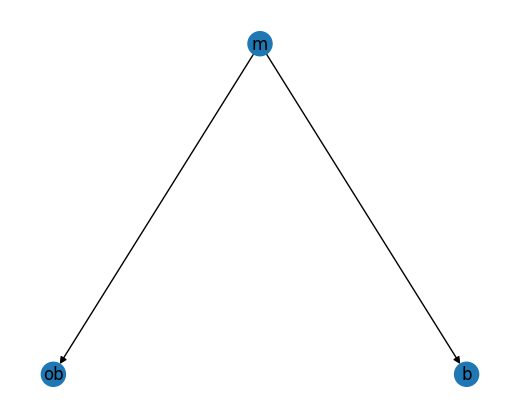

In [26]:
Omega33 = ['m','b','ob']

rel33 = reflexive_closure([('b','m'),('ob','m')], Omega33)

draw_digraph(rel33,[],width=5)


In [27]:
RO33 = RO(rel33)

print(RO33)

[[], ['ob'], ['b'], ['ob', 'm', 'b']]


### Awareness correspondence

In [28]:
a_corr33 = {'b':Omega33,'ob':['m'],'m':['m']}

print("Nonvacuity is", nonvacuity(rel33,a_corr33))

print("Expressibility is", expressibility(rel33,a_corr33))

print("Persistence is", persistence(rel33,a_corr33))

print("Refinability is", refinability(rel33,a_corr33))

print("Joinability is", joinability(rel33,a_corr33))

  0%|          | 0/3 [00:00<?, ?it/s]

Nonvacuity is True


  0%|          | 0/3 [00:00<?, ?it/s]

Expressibility is True


  0%|          | 0/5 [00:00<?, ?it/s]

Persistence is True


  0%|          | 0/3 [00:00<?, ?it/s]

Refinability is True


  0%|          | 0/3 [00:00<?, ?it/s]

Joinability is True


### Computing events

In [29]:
Barks = ['b']

print("")

print("States where Watson is aware of Barks:", aware(Barks,rel33,a_corr33))

print("States where it it settled that Watson is unaware of Barks:", neg(aware(Barks,rel33,a_corr33),rel33))


States where Watson is aware of Barks: ['b']
States where it it settled that Watson is unaware of Barks: ['ob']


In [30]:
#Checking if AU Introspection holds...

AU = True

for E in tqdm(RO33):
    UE = set(unaware(E,rel33,a_corr33))
    UUE = set(unaware(UE,rel33,a_corr33)) 

    if not UE.issubset(UUE):
        AU = False

if AU == True:
    print("AU Introspection satisfied.")
else:
    print("AU Introspection violated!")

  0%|          | 0/4 [00:00<?, ?it/s]

AU Introspection satisfied.


## Example 3.4

### Set of possibilities

In [31]:
Omega34 = ['m']

for letter in ['g','l','r']:
    Omega34.append(letter)
    Omega34.append('_'+letter)

for first in ['l','r']:
    for second in ['u','d']:
        for third in ['','1','2']:
            Omega34.append(first+second+third)
            Omega34.append('_'+first+second+third)

for first in ['l','r']:
    for third in ['','1','2']:
        Omega34.append('_'+first+'m'+third)

print(Omega34)
print(len(Omega34))

['m', 'g', '_g', 'l', '_l', 'r', '_r', 'lu', '_lu', 'lu1', '_lu1', 'lu2', '_lu2', 'ld', '_ld', 'ld1', '_ld1', 'ld2', '_ld2', 'ru', '_ru', 'ru1', '_ru1', 'ru2', '_ru2', 'rd', '_rd', 'rd1', '_rd1', 'rd2', '_rd2', '_lm', '_lm1', '_lm2', '_rm', '_rm1', '_rm2']
37


### Refinement relation

In [32]:
rel34 = []

for omega1 in Omega34:
    for omega2 in Omega34:
        if omega2.startswith(omega1):
            rel34.append((omega2,omega1))

for omega in Omega34:
    if not '_' in omega and 'm' not in omega:
        rel34.append((omega,'g'))

for omega in Omega34:
    if '_' in omega:
        rel34.append((omega,'_g'))

for omega in Omega34:
    rel34.append((omega,'m'))


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


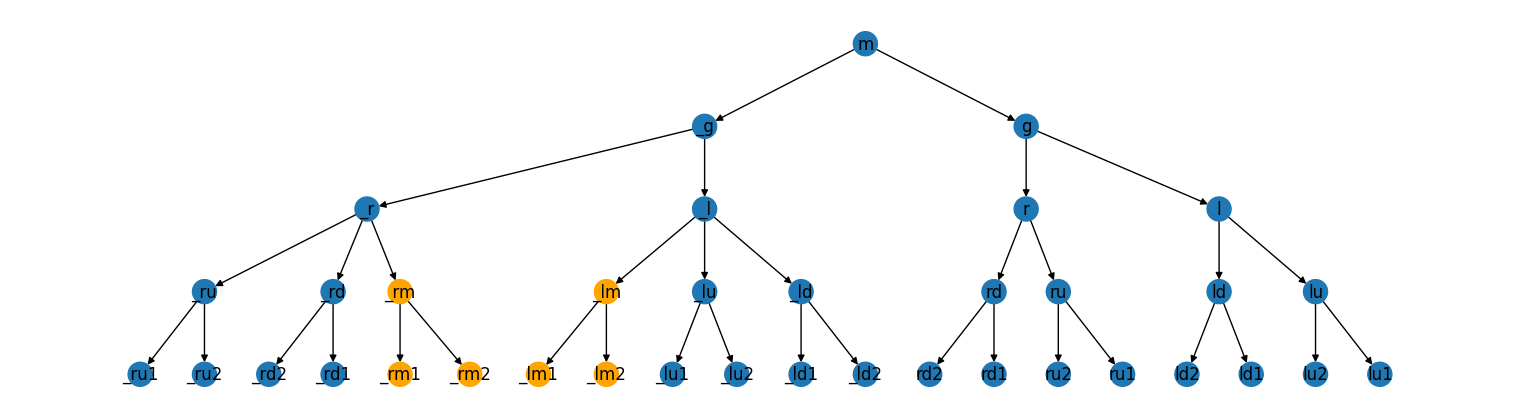

In [33]:
Middle = down(['_lm','_rm'],rel34)

draw_digraph(rel34, Middle)

In [34]:
print(minimal_elements(Omega34,rel34))

['lu1', '_lu1', 'lu2', '_lu2', 'ld1', '_ld1', 'ld2', '_ld2', 'ru1', '_ru1', 'ru2', '_ru2', 'rd1', '_rd1', 'rd2', '_rd2', '_lm1', '_lm2', '_rm1', '_rm2']


### Awareness correspondence

In [35]:
a_corr34 = dict()

for omega in Omega34:
    if not omega.endswith('2'):
        a_corr34[omega] = ['m','g','_g','l','r','lu','ld','ru','rd']
    
    else:
        a_corr34[omega] = Omega34

In [36]:
print("Checking nonvacuity...")
print("Nonvacuity is", nonvacuity(rel34,a_corr34))

print('')

print("Checking expressibility...")
print("Expressibility is", expressibility(rel34,a_corr34))

print('')

print("Checking persistence...")
print("Persistence is", persistence(rel34,a_corr34))

print('')

print("Checking refinability...")
print("Refinability is", refinability(rel34,a_corr34))

print('')

print("Checking joinability...")
print("Joinability is", joinability(rel34,a_corr34))

Checking nonvacuity...


  0%|          | 0/37 [00:00<?, ?it/s]

Nonvacuity is True

Checking expressibility...


  0%|          | 0/37 [00:00<?, ?it/s]

Expressibility is True

Checking persistence...


  0%|          | 0/160 [00:00<?, ?it/s]

Persistence is True

Checking refinability...


  0%|          | 0/37 [00:00<?, ?it/s]

Refinability is True

Checking joinability...


  0%|          | 0/37 [00:00<?, ?it/s]

Joinability is True


### Computing events

States where the agent is aware of Middle:


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


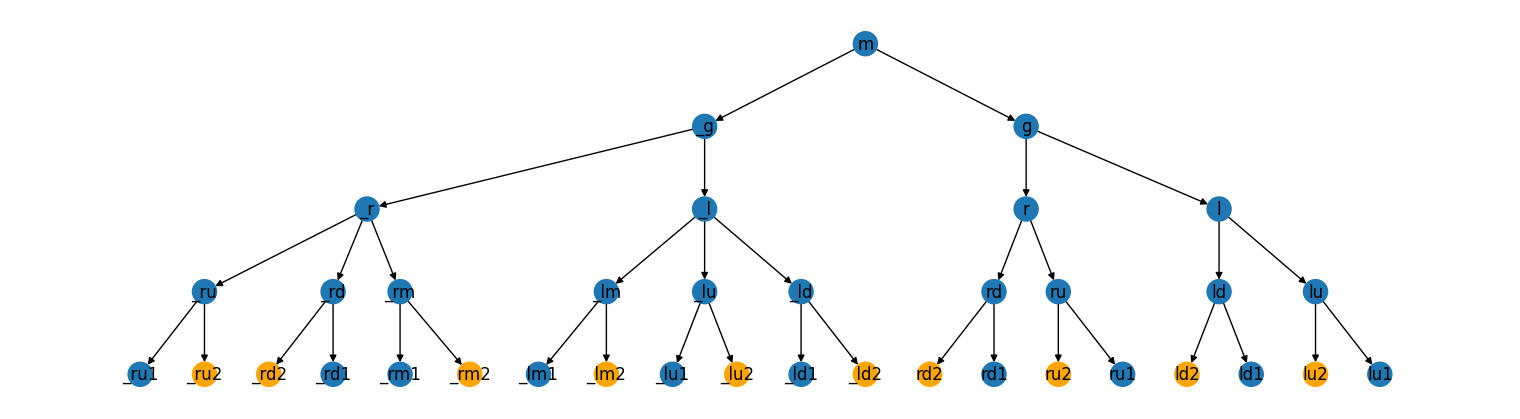

In [37]:
Middle = down(['_lm','_rm'],rel34)

print("States where the agent is aware of Middle:")

draw_digraph(rel34, aware(Middle,rel34,a_corr34))

States where the agent is unaware of Middle:


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


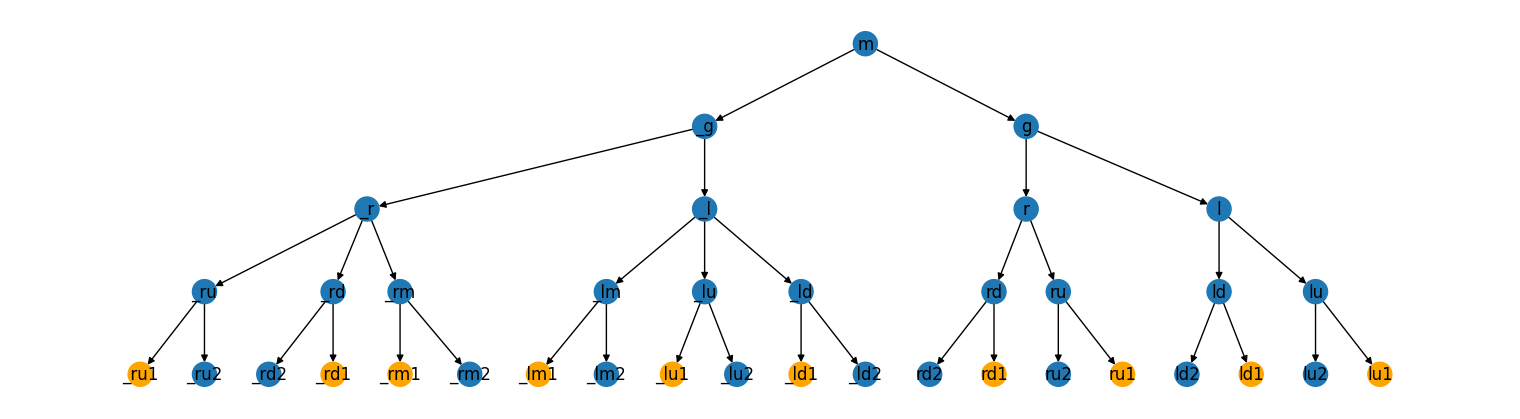

In [38]:
print("States where the agent is unaware of Middle:")

draw_digraph(rel34, neg(aware(Middle,rel34,a_corr34),rel34))

States where the agent is unaware of being unaware of Middle:


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


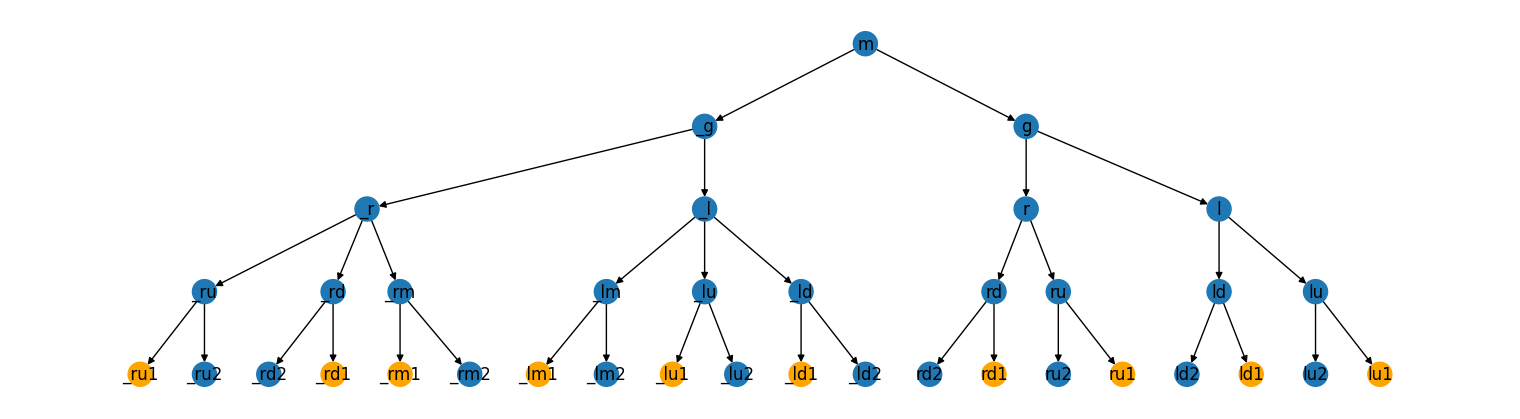

In [39]:
UMiddle = neg(aware(Middle,rel34,a_corr34),rel34)
UUMiddle = neg(aware(UMiddle,rel34,a_corr34),rel34)

print("States where the agent is unaware of being unaware of Middle:")

draw_digraph(rel34, UUMiddle)

States where the agent is aware of Up:


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


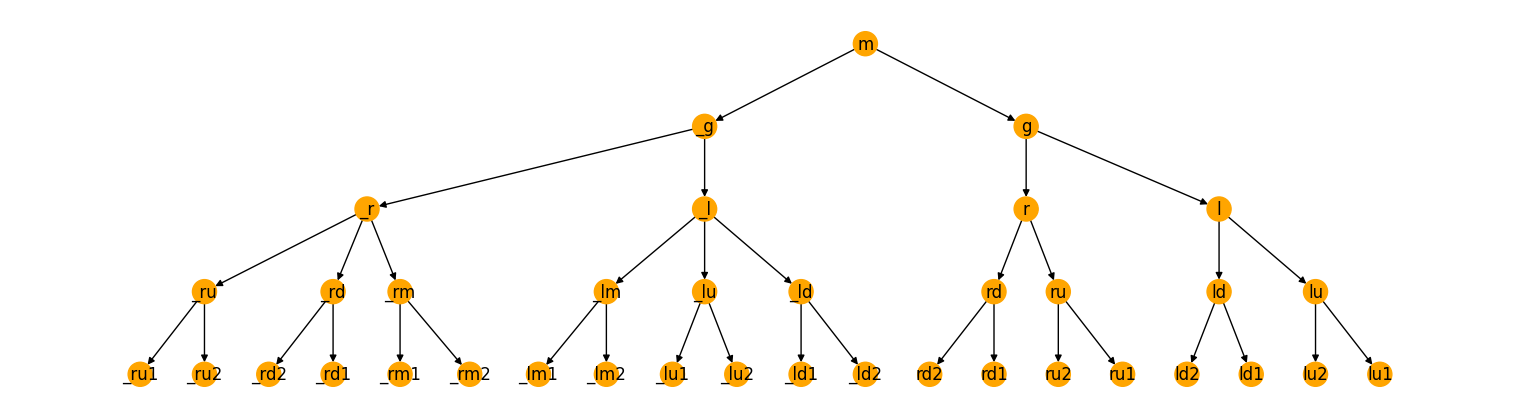

In [40]:
Up = down(['lu','ru'],rel34)

print("States where the agent is aware of Up:")

draw_digraph(rel34, aware(Up,rel34,a_corr34))

# 3.2 Knowledge, belief, and awareness

In [41]:
def monotonicity(rel,corr):

    dom = domain(rel)

    for pair in rel:
        if not set(corr[pair[0]]).issubset(set(corr[pair[1]])):
            print("Monotonicity is violated with respect to", pair)
            return False

    return True

In [42]:
def regularity(rel,corr):

    dom = domain(rel)

    for x in dom:
        if not set(rho(corr[x],rel)) == set(corr[x]):
            print("Regularity is violated with respect to", x)
            return False
    
    return True

In [43]:
def refinability(rel,corr):
    
    dom = domain(rel)

    for x in dom:
        for y in corr[x]:
            down_y = set(down([y],rel))
            if x not in closure(interior([z for z in dom if len(down_y.intersection(set(corr[z]))) > 0],rel),rel):
                pair = (x,y)
                print("Refinability is violated with respect to", pair)
                return False

    return True


In [44]:
def factivity(rel,corr):

    dom = domain(rel)

    for x in dom:
        if not x in corr[x]:
            return False
            
    return True

In [45]:
def consistency(rel,corr):

    dom = domain(rel)

    for x in dom:
        if len(corr[x]) == 0:
            return False
            
    return True

In [46]:
def doxastic_inclusion(rel,k_corr,b_corr):

    dom = domain(rel)

    for x in dom:
        if not set(b_corr[x]).issubset(set(k_corr[x])):
            return False
            
    return True

In [47]:
def implicit_know(A, rel, k_corr):
    dom = domain(rel)
    setA = set(A)
    return [x for x in dom if set(k_corr[x]).issubset(setA)]

def implicit_believe(A, rel, b_corr):
    dom = domain(rel)
    setA = set(A)
    return [x for x in dom if set(b_corr[x]).issubset(setA)]

def know(A, rel, a_corr, k_corr):
    dom = domain(rel)
    setA = set(A)
    return [x for x in dom if x in implicit_know(A,rel,k_corr) and x in aware(A,rel,a_corr)]

def believe(A, rel, a_corr, b_corr):
    dom = domain(rel)
    setA = set(A)
    return [x for x in dom if x in implicit_believe(A,rel,b_corr) and x in aware(A,rel,a_corr)]

## Example 3.8

In [48]:
k_corr38 = dict()

k_corr38['b'] = ['b']
k_corr38['ob'] = Omega33
k_corr38['m'] = Omega33

b_corr38 = dict()

b_corr38['b'] = ['b']
b_corr38['ob'] = Omega33
b_corr38['m'] = Omega33

In [49]:
print("Checking monotonicity...")
print("Monotonicity is", monotonicity(rel33,k_corr38))

print('')

print("Checking regularity...")
print("Regularity is", regularity(rel33,k_corr38))

print('')

print("Checking refinability...")
print("Refinability is", refinability(rel33,k_corr38))

print('')

print("Checking epistemic factivity...")
print("Epistemic factivity is", factivity(rel33,k_corr38))

print('')

print("Checking doxastic consistency...")
print("Doxastic consistency is", consistency(rel33,b_corr38))

print('')

print("Checking doxastic inclusion...")
print("Doxastic inclusion is", doxastic_inclusion(rel33,k_corr38,b_corr38))

Checking monotonicity...
Monotonicity is True

Checking regularity...
Regularity is True

Checking refinability...
Refinability is True

Checking epistemic factivity...
Epistemic factivity is True

Checking doxastic consistency...
Doxastic consistency is True

Checking doxastic inclusion...
Doxastic inclusion is True


In [50]:
k_corr38prime = dict()
b_corr38prime = dict()

k_corr38prime['b'] = ['b']
k_corr38prime['ob'] = ['ob']
k_corr38prime['m'] = Omega33

b_corr38prime['b'] = ['b']
b_corr38prime['ob'] = ['ob']
b_corr38prime['m'] = Omega33

In [51]:
print("Checking epistemic monotonicity...")
print("Epistemic monotonicity is", monotonicity(rel33,k_corr38prime))

print('')

print("Checking doxastic monotonicity...")
print("Doxastic monotonicity is", monotonicity(rel33,b_corr38prime))

print('')

print("Checking regularity...")
print("Regularity is", regularity(rel33,k_corr38prime))

print('')

print("Checking doxastic regularity...")
print("Doxastic regularity is", regularity(rel33,b_corr38prime))

print('')

print("Checking epistemic refinability...")
print("Epistemic refinability is", refinability(rel33,k_corr38prime))

print('')

print("Checking doxastic refinability...")
print("Doxastic refinability is", refinability(rel33,b_corr38prime))

print('')

print("Checking epistemic factivity...")
print("Epistemic factivity is", factivity(rel33,k_corr38prime))

print('')

print("Checking doxastic consistency...")
print("Doxastic consistency is", consistency(rel33,b_corr38prime))

print('')

print("Checking doxastic inclusion...")
print("Doxastic inclusion is", doxastic_inclusion(rel33,k_corr38prime,b_corr38prime))

Checking epistemic monotonicity...
Epistemic monotonicity is True

Checking doxastic monotonicity...
Doxastic monotonicity is True

Checking regularity...
Regularity is True

Checking doxastic regularity...
Doxastic regularity is True

Checking epistemic refinability...
Epistemic refinability is True

Checking doxastic refinability...
Doxastic refinability is True

Checking epistemic factivity...
Epistemic factivity is True

Checking doxastic consistency...
Doxastic consistency is True

Checking doxastic inclusion...
Doxastic inclusion is True


In [52]:
#Checking that the two knowledge correspondences agree on explicit knowledge

for E in powerset(Omega33):
    if not know(E, rel33, a_corr33, k_corr38) == know(E, rel33, a_corr33, k_corr38prime):
        print("Not equal on",E)
        break

print("Equal!")

Equal!


In [53]:
print("States where Watson knows Barks:", know(Barks,rel33,a_corr33,k_corr38prime))

print("States where it it settled that Watson does not know Barks:", neg(know(Barks,rel33,a_corr33,k_corr38prime),rel33))


States where Watson knows Barks: ['b']
States where it it settled that Watson does not know Barks: ['ob']


In [54]:
#Checking if Nontrivial Plausibility holds

NP = True

for E in RO33:

    KE = know(E, rel33,a_corr33,k_corr38prime)
    nKE = neg(KE,rel33)

    if not set(nKE) == set(Omega33):

        UE = set(unaware(E,rel33,a_corr33))
        KnKE = know(nKE, rel33,a_corr33,k_corr38prime)
        nKnKE = neg(KnKE,rel33)

        if not UE.issubset(nKnKE):
            NP = False

if NP == True:
    print("Nontrivial Plausibility satisfied.")
else:
    print("Nontrivial Plausibility violated.")


Nontrivial Plausibility satisfied.


In [55]:
#Checking if KU Introspection holds

KU = True
for E in RO33:

    UE = set(unaware(E,rel33,a_corr33))

    if len(know(UE,rel33,a_corr33,k_corr38prime)) > 0:
        KU = False

if KU == True:
    print("KU Introspection satisfied.")
else:
    print("KU Introspection violated.")

KU Introspection satisfied.


## Example 3.9

### Set of possibilities

In [56]:
Omega39 = ['m','p','_p']

for first in ['p','_p']:
    for second in ['b','_b']:
        for third in ['u','_u','']:
            Omega39.append(first+second+third)

for state in Omega39:
    if state.startswith('_') and (state.endswith('u') or state.endswith('_u')):
                Omega39.append(state+'f')
                Omega39.append(state+'_f')

print(Omega39)
print(len(Omega39))

['m', 'p', '_p', 'pbu', 'pb_u', 'pb', 'p_bu', 'p_b_u', 'p_b', '_pbu', '_pb_u', '_pb', '_p_bu', '_p_b_u', '_p_b', '_pbuf', '_pbu_f', '_pb_uf', '_pb_u_f', '_p_buf', '_p_bu_f', '_p_b_uf', '_p_b_u_f']
23


### Refinement relation

In [57]:
rel39 = []

for omega1 in Omega39:
    for omega2 in Omega39:
        if omega2.startswith(omega1):
            rel39.append((omega2,omega1))

for omega in Omega39:
    rel39.append((omega,'m'))

In [58]:
print(rel39)

[('m', 'm'), ('p', 'p'), ('pbu', 'p'), ('pb_u', 'p'), ('pb', 'p'), ('p_bu', 'p'), ('p_b_u', 'p'), ('p_b', 'p'), ('_p', '_p'), ('_pbu', '_p'), ('_pb_u', '_p'), ('_pb', '_p'), ('_p_bu', '_p'), ('_p_b_u', '_p'), ('_p_b', '_p'), ('_pbuf', '_p'), ('_pbu_f', '_p'), ('_pb_uf', '_p'), ('_pb_u_f', '_p'), ('_p_buf', '_p'), ('_p_bu_f', '_p'), ('_p_b_uf', '_p'), ('_p_b_u_f', '_p'), ('pbu', 'pbu'), ('pb_u', 'pb_u'), ('pbu', 'pb'), ('pb_u', 'pb'), ('pb', 'pb'), ('p_bu', 'p_bu'), ('p_b_u', 'p_b_u'), ('p_bu', 'p_b'), ('p_b_u', 'p_b'), ('p_b', 'p_b'), ('_pbu', '_pbu'), ('_pbuf', '_pbu'), ('_pbu_f', '_pbu'), ('_pb_u', '_pb_u'), ('_pb_uf', '_pb_u'), ('_pb_u_f', '_pb_u'), ('_pbu', '_pb'), ('_pb_u', '_pb'), ('_pb', '_pb'), ('_pbuf', '_pb'), ('_pbu_f', '_pb'), ('_pb_uf', '_pb'), ('_pb_u_f', '_pb'), ('_p_bu', '_p_bu'), ('_p_buf', '_p_bu'), ('_p_bu_f', '_p_bu'), ('_p_b_u', '_p_b_u'), ('_p_b_uf', '_p_b_u'), ('_p_b_u_f', '_p_b_u'), ('_p_bu', '_p_b'), ('_p_b_u', '_p_b'), ('_p_b', '_p_b'), ('_p_buf', '_p_b'), ('_

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


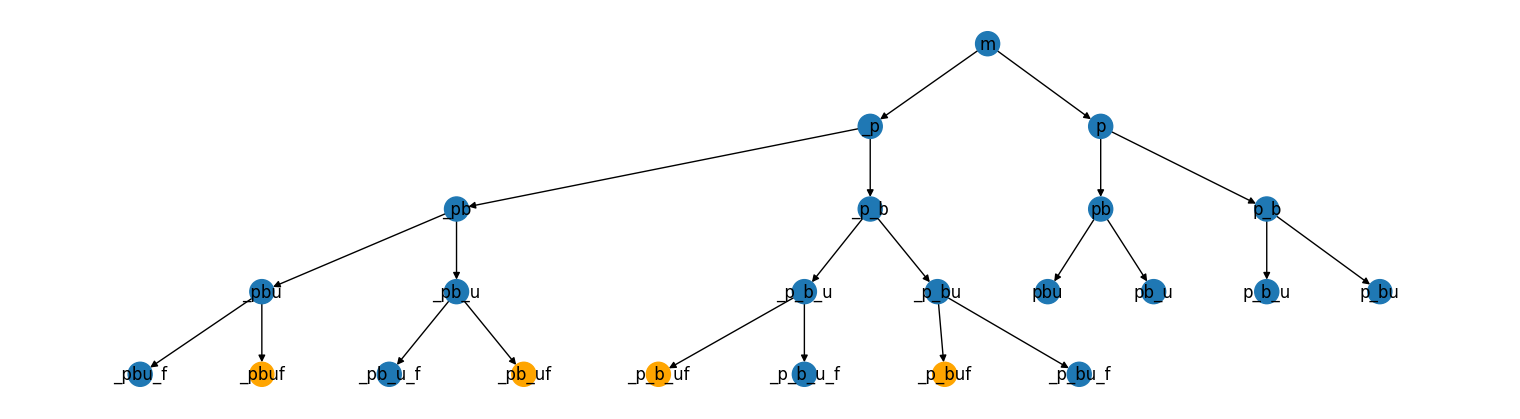

In [59]:
Fraud = [omega for omega in Omega39 if omega.endswith('f') and not omega.endswith('_f')]

draw_digraph(rel39,Fraud)

In [60]:
RO39 = RO(rel39)
len(RO39)

4096

### Awareness correspondence

In [61]:
a_corr39 = dict()

for omega in Omega39:
    if '_u' in omega:
        a_corr39[omega] = Omega39
    
    else:
        a_corr39[omega] = [nu for nu in Omega39 if 'u' not in nu]

In [62]:
print("Checking nonvacuity...")
print("Nonvacuity is", nonvacuity(rel39,a_corr39))

print('')

print("Checking expressibility...")
print("Expressibility is", expressibility(rel39,a_corr39))

print('')

print("Checking persistence...")
print("Persistence is", persistence(rel39,a_corr39))

print('')

print("Checking refinability...")
print("Refinability is", refinability(rel39,a_corr39))

print('')

print("Checking joinability...")
print("Joinability is", joinability(rel39,a_corr39))

Checking nonvacuity...


  0%|          | 0/23 [00:00<?, ?it/s]

Nonvacuity is True

Checking expressibility...


  0%|          | 0/23 [00:00<?, ?it/s]

Expressibility is True

Checking persistence...


  0%|          | 0/90 [00:00<?, ?it/s]

Persistence is True

Checking refinability...
Refinability is True

Checking joinability...


  0%|          | 0/23 [00:00<?, ?it/s]

Joinability is True


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


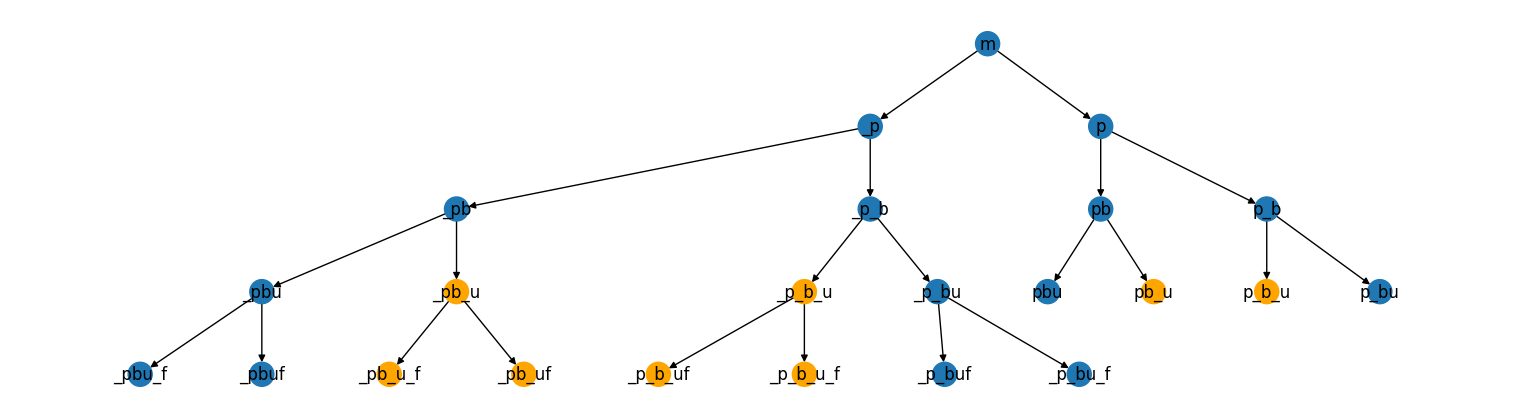

In [63]:
draw_digraph(rel39,aware(Fraud,rel39,a_corr39))

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


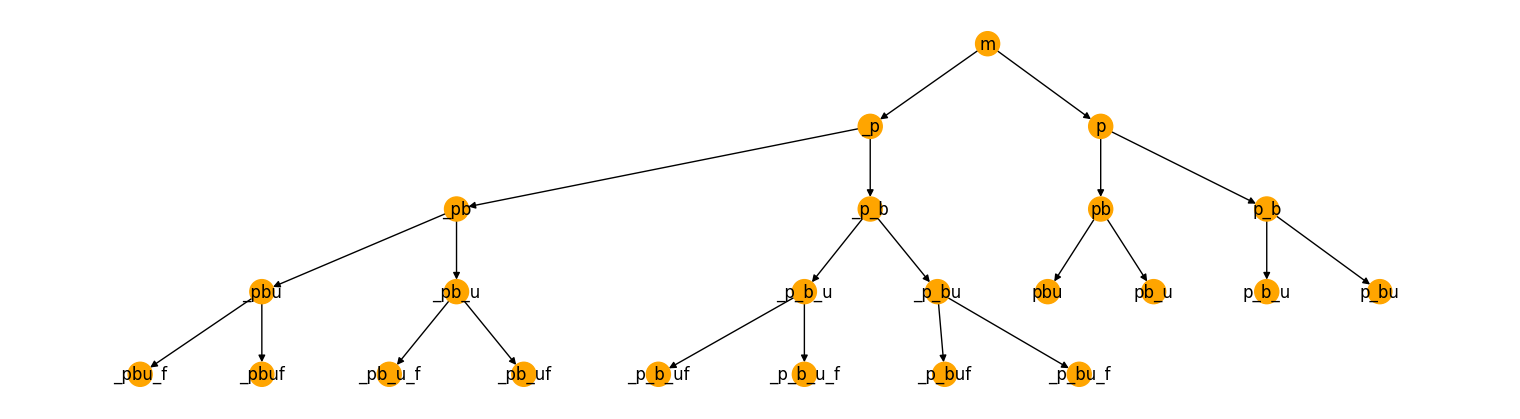

In [64]:
Profit = down(['p'],rel39)

draw_digraph(rel39,aware(Profit,rel39,a_corr39))


### Knowledge and belief correspondence

In [65]:
k_corr39 = dict()

k_corr39['pb'] = down(['pb'],rel39) # Square state in paper
k_corr39['_pb'] = down(['pb','_pb'],rel39) # Square state in paper

k_corr39['p_b'] = down(['p_b','_p_b'],rel39) # Diamond state in paper
k_corr39['_p_b'] = down(['p_b','_p_b'],rel39) # Diamond state in paper

for omega in Omega39:

    if 'bu' in omega and not '_bu' in omega: # So omega is a blue state in the paper
        k_corr39[omega] = down([omega,'pb'],rel39)
    
    if 'b_u' in omega and not '_b_u' in omega: # So omega is a black state in the paper
        k_corr39[omega] = down([omega,'pb_u'],rel39)

    if '_bu' in omega: # So omega is a green state in the paper
        k_corr39[omega] = down(['p_b','_p_b'],rel39)

    if '_b_u' in omega: # So omega is a gray state in the paper
        k_corr39[omega] = [nu for nu in Omega39 if '_b_u' in nu]


k_corr39['p'] = []
k_corr39['p'] = rho([nu for nu in Omega39 if any ([nu in k_corr39[omegaprime] for omegaprime in down(['p'],rel39)])],rel39)

k_corr39['_p'] = []
k_corr39['_p'] = rho([nu for nu in Omega39 if any ([nu in k_corr39[omegaprime] for omegaprime in down(['_p'],rel39)])],rel39)

k_corr39['m'] = []
k_corr39['m'] = rho([nu for nu in Omega39 if any ([nu in k_corr39[omegaprime] for omegaprime in down(['m'],rel39)])],rel39)


/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


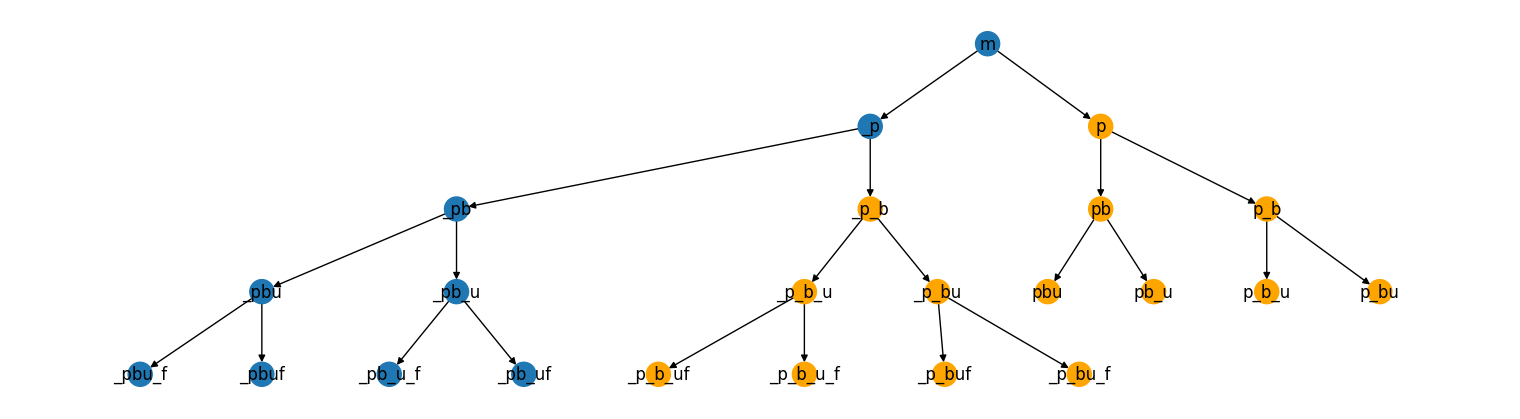

In [66]:
draw_digraph(rel39,k_corr39['p'])

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


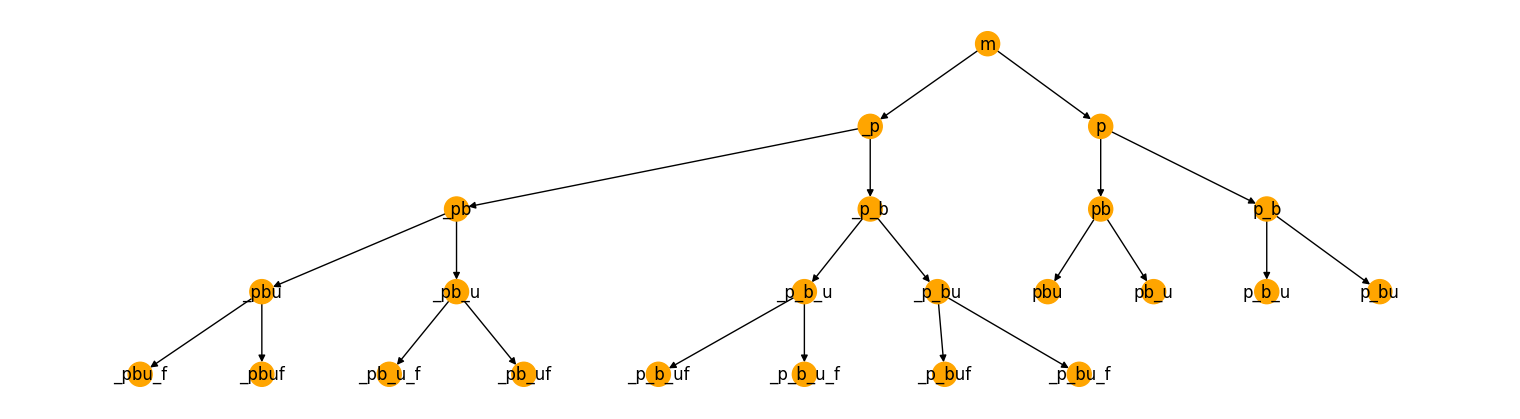

In [67]:
draw_digraph(rel39,k_corr39['_p'])

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


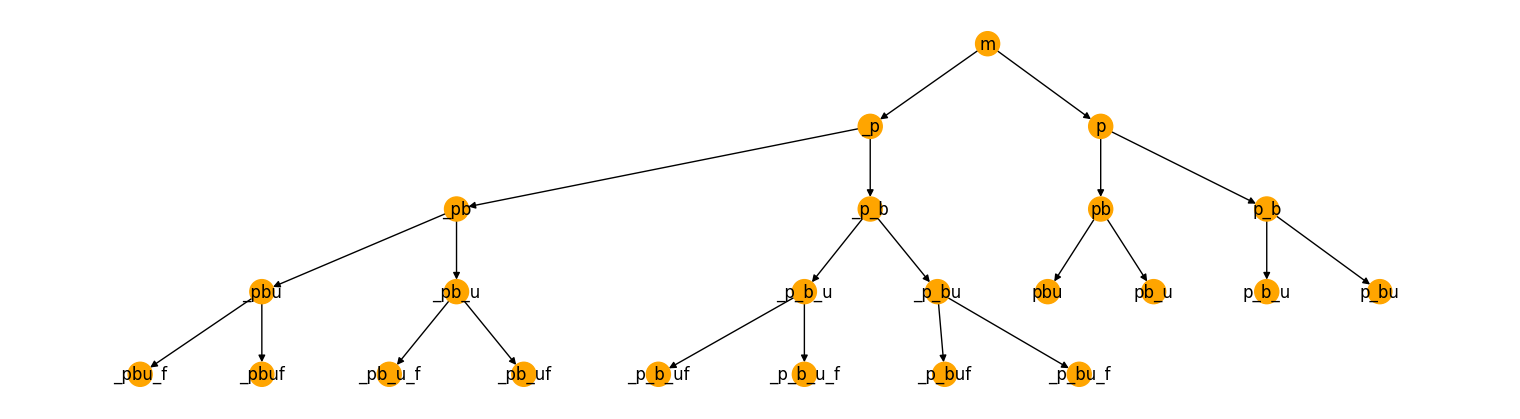

In [68]:
draw_digraph(rel39,k_corr39['m'])

In [69]:
b_corr39 = dict()

b_corr39['pb'] = down(['pb'],rel39) # Square state in paper
b_corr39['_pb'] = down(['pb'],rel39) # Square state in paper

b_corr39['p_b'] = down(['p_b','_p_b'],rel39) # Diamond state in paper
b_corr39['_p_b'] = down(['p_b','_p_b'],rel39) # Diamond state in paper

for omega in Omega39:

    if 'bu' in omega and not '_bu' in omega: # So omega is a blue state in the paper
        b_corr39[omega] = down(['pb'],rel39)
    
    if 'b_u' in omega and not '_b_u' in omega: # So omega is a black state in the paper
        b_corr39[omega] = ['pb_u']

    if '_bu' in omega: # So omega is a green state in the paper
        b_corr39[omega] = down(['p_b','_p_b'],rel39)

    if '_b_u' in omega: # So omega is a gray state in the paper
        b_corr39[omega] = [nu for nu in Omega39 if '_b_u' in nu]

b_corr39['p'] = []
b_corr39['p'] = rho([nu for nu in Omega39 if any ([nu in b_corr39[omegaprime] for omegaprime in down(['p'],rel39)])],rel39)

b_corr39['_p'] = []
b_corr39['_p'] = rho([nu for nu in Omega39 if any ([nu in b_corr39[omegaprime] for omegaprime in down(['_p'],rel39)])],rel39)

b_corr39['m'] = []
b_corr39['m'] = rho([nu for nu in Omega39 if any ([nu in b_corr39[omegaprime] for omegaprime in down(['p'],rel39)])],rel39)
        

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


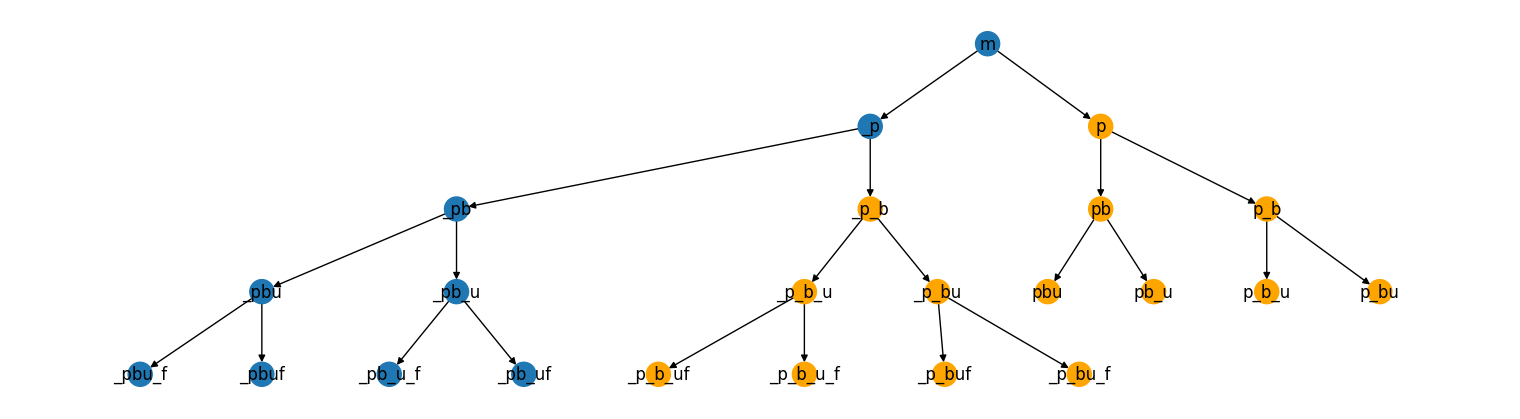

In [70]:
draw_digraph(rel39,b_corr39['p'])

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


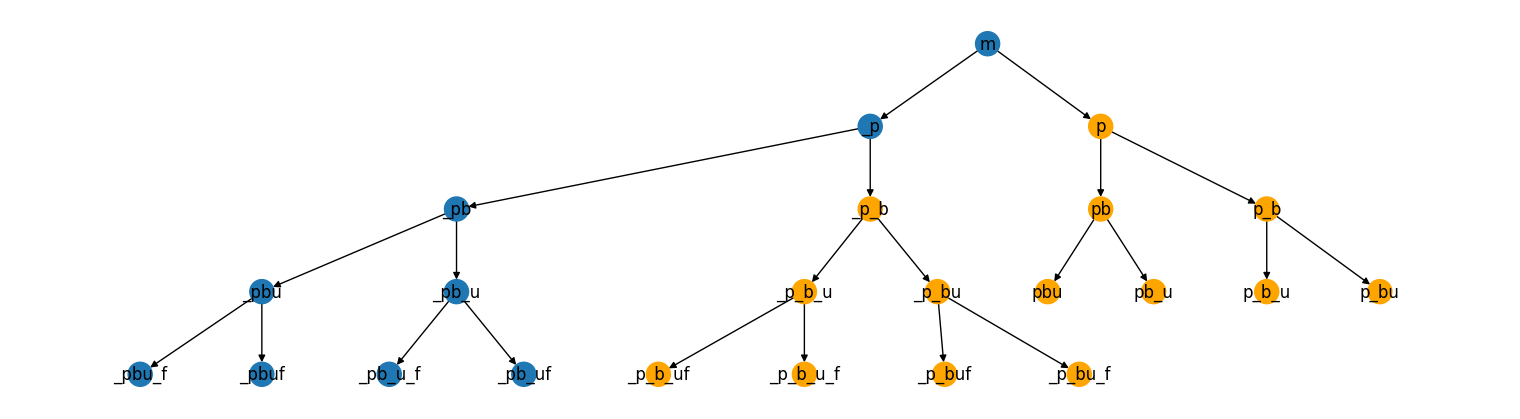

In [71]:
draw_digraph(rel39,b_corr39['_p'])

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


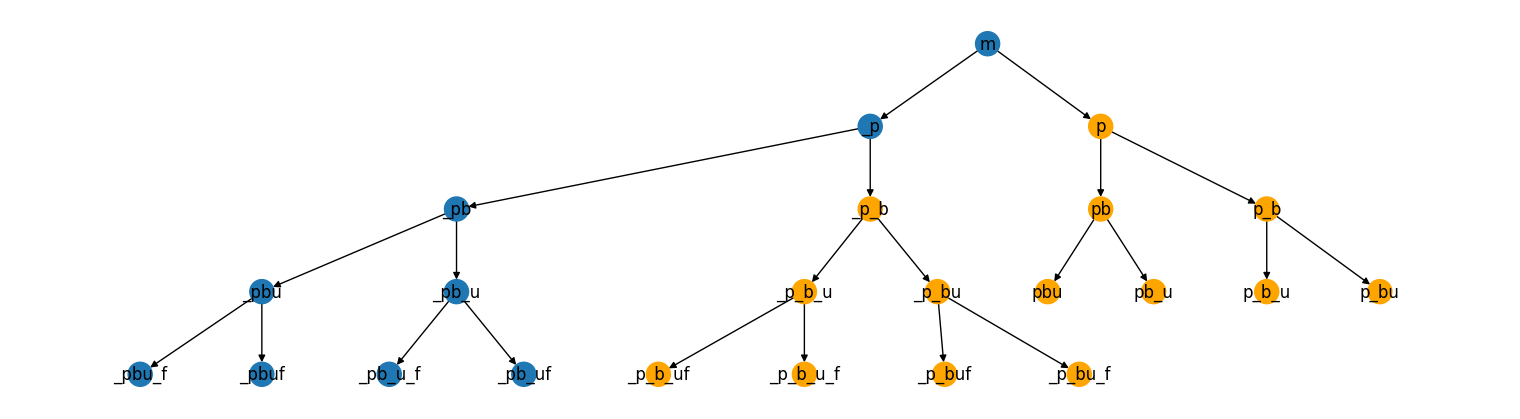

In [72]:
draw_digraph(rel39,b_corr39['m'])

In [73]:
print("Checking epistemic monotonicity...")
print("Epistemic monotonicity is", monotonicity(rel39,k_corr39))

print('')

print("Checking doxastic monotonicity...")
print("Doxastic monotonicity is", monotonicity(rel39,b_corr39))

print('')

print("Checking epistemic regularity...")
print("Epistemic regularity is", regularity(rel39,k_corr39))

print('')

print("Checking doxastic regularity...")
print("Doxastic regularity is", regularity(rel39,b_corr39))

print('')

print("Checking epistemic refinability...")
print("Episttemic refinability is", refinability(rel39,k_corr39))

print('')

print("Checking doxastic refinability...")
print("Doxastic refinability is", refinability(rel39,b_corr39))

print('')

print("Checking epistemic factivity...")
print("Epistemic factivity is", factivity(rel39,k_corr39))

print('')

print("Checking doxastic consistency...")
print("Doxastic consistency is", consistency(rel39,b_corr39))

print('')

print("Checking doxastic inclusion...")
print("Doxastic inclusion is", doxastic_inclusion(rel39,k_corr39,b_corr39))

Checking epistemic monotonicity...
Epistemic monotonicity is True

Checking doxastic monotonicity...
Doxastic monotonicity is True

Checking epistemic regularity...
Epistemic regularity is True

Checking doxastic regularity...
Doxastic regularity is True

Checking epistemic refinability...
Episttemic refinability is True

Checking doxastic refinability...
Doxastic refinability is True

Checking epistemic factivity...
Epistemic factivity is True

Checking doxastic consistency...
Doxastic consistency is True

Checking doxastic inclusion...
Doxastic inclusion is True


## Verification of Remark 3.7

In [74]:
def sufficient_for_A_implies_AA(rel,corr):

    dom = domain(rel)
    setdom = set(dom)

    for omega in dom:
        setcorromega = set(corr[omega])
        if not setcorromega == setdom:
            for nu in corr[omega]:
                for nuprime in down([nu],rel):
                    setcorrnuprime = set(corr[nuprime])
                    if not setcorrnuprime == setdom:
                        witness = False
                        for omegaprime in down([omega],rel):
                            if set(corr[omegaprime]) == setcorrnuprime:
                                witness = True
                        if witness == False:
                            return False

    return True

In [75]:
sufficient_for_A_implies_AA(rel33,a_corr33)

True

In [76]:
sufficient_for_A_implies_AA(rel34,a_corr34)

True

In [77]:
def sufficient_for_A_implies_KA(rel,corr,k_corr):

    if not sufficient_for_A_implies_AA(rel,corr):
        return False

    dom = domain(rel)
    setdom = set(dom)

    for omega in dom:
        for nu in k_corr[omega]:
            for nuprime in down([nu],rel):
                setcorrnuprime = set(corr[nuprime])
                if not setcorrnuprime == setdom:
                    witness = False
                    for omegaprime in down([omega],rel):
                        if set(corr[omegaprime]) == setcorrnuprime:
                            witness = True
                    if witness == False:
                        return False

    return True

In [78]:
sufficient_for_A_implies_KA(rel39,a_corr39,k_corr39)

True

## Verification of Footnote 16

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


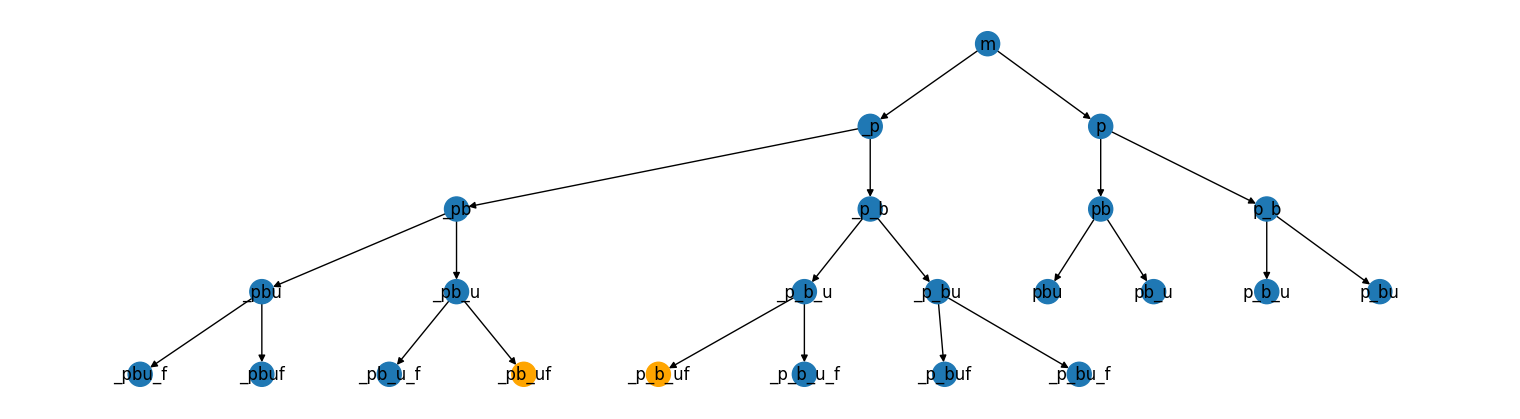

In [79]:
setFraud = set(Fraud)
AFraud = aware(Fraud,rel39,a_corr39)
KFraud = know(Fraud,rel39,a_corr39,k_corr39)
nKFraud = set(neg(KFraud,rel39))

Eprime = setFraud.intersection(AFraud,nKFraud)

draw_digraph(rel39,Eprime)

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_16202/713667227.py:26: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


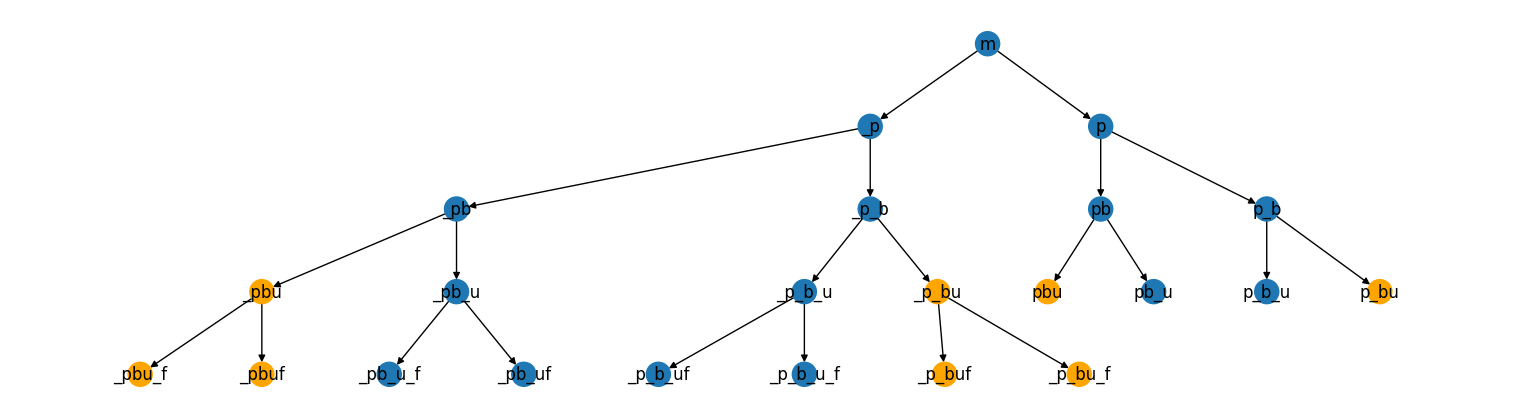

In [80]:
UEprime = unaware(Eprime,rel39,a_corr39)

draw_digraph(rel39,UEprime)

## Verification of Remark 3.10 for Example 3.9

In [81]:
#Verifying Positive Introspection for knowledge takes about 20 minutes

AU = True
for E in tqdm(RO39):
    KE = set(know(E,rel39,a_corr39,k_corr39))
    KKE = set(know(KE,rel39,a_corr39,k_corr39)) 

    if not KE.issubset(KKE):
        AU = False
        break

if AU == True:
    print("Positive Introspection for knowledge satisfied.")
else:
    print("Positive Introspection for knowledge violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

Positive Introspection for knowledge satisfied.


In [82]:
#Verifying Positive Introspection for belief take about 30 minutes

AU = True
for E in tqdm(RO39):
    BE = set(believe(E,rel39,a_corr39,b_corr39))
    KBE = set(know(BE,rel39,a_corr39,b_corr39)) 

    if not BE.issubset(KBE):
        AU = False
        break

if AU == True:
    print("Positive Introspection for belief satisfied.")
else:
    print("Positive Introspection for belief violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

Positive Introspection for belief satisfied.


In [83]:
#Verifying Stalnaker's strong belief principle takes about 1 hour

value = True
for E in tqdm(RO39):
    BE = set(believe(E,rel39,a_corr39,b_corr39))
    KE = set(know(E,rel39,a_corr39,k_corr39))
    BKE = set(believe(KE,rel39,a_corr39,b_corr39)) 

    if not BE.issubset(BKE):
        value = False
        break

if value == True:
    print("Stalnaker's strong belief principle satisfied.")
else:
    print("Stalnaker's strong belief principle violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

Stalnaker's strong belief principle satisfied.


In [84]:
#Verifying Weak Negative Introspection for belief takes about 2 hours

value = True
for E in tqdm(RO39):
    BE = set(believe(E,rel39,a_corr39,b_corr39))
    nBE = set(neg(BE,rel39))
    AnBE = set(aware(nBE,rel39,a_corr39))
    KnBE = set(know(nBE,rel39,a_corr39,k_corr39)) 

    if not (nBE.intersection(AnBE)).issubset(KnBE):
        value = False
        break

if value == True:
    print("Weak Negative Introspection for belief satisfied.")
else:
    print("Weak Negative Introspection for belief violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

Weak Negative Introspection for belief satisfied.


## Verification of Fact 3.11 for Example 3.9

In [85]:
#Verifying KU Introspection takes about 5 minutes

KU = True
for E in tqdm(RO39):

    UE = set(unaware(E,rel39,a_corr39))

    if len(know(UE,rel39,a_corr39,k_corr39)) > 0:
        KU = False
        break

if KU == True:
    print("KU Introspection satisfied.")
else:
    print("KU Introspection violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

KU Introspection satisfied.


In [86]:
#Verifying AU Introspection takes about 10 minutes

AU = True
for E in tqdm(RO39):
    UE = set(unaware(E,rel39,a_corr39))
    UUE = set(unaware(UE,rel39,a_corr39)) 

    if not UE.issubset(UUE):
        AU = False
        break

if AU == True:
    print("AU Introspection satisfied.")
else:
    print("AU Introspection violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

AU Introspection satisfied.


In [87]:
#Verifying Nontrivial Plausibility takes about 50 minutes

NP = True

for E in tqdm(RO39):

    KE = know(E, rel39,a_corr39,k_corr39)
    nKE = neg(KE,rel39)

    if not set(nKE) == set(Omega39):

        UE = set(unaware(E,rel39,a_corr39))
        KnKE = know(nKE, rel39,a_corr39,k_corr39)
        nKnKE = neg(KnKE,rel39)

        if not UE.issubset(nKnKE):
            NP = False
            break

if NP == True:
    print("Nontrivial Plausibility satisfied.")
else:
    print("Nontrivial Plausibility violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

Nontrivial Plausibility satisfied.


## Verification of Footnote 18 for Example 3.9

In [88]:
#Verifying Nontrivial AK-Self Reflection takes about 40 minutes

value = True
for E in tqdm(RO39):
    AE = set(aware(E,rel39,a_corr39))
    KE = set(know(E,rel39,a_corr39,k_corr39))
    AKE = set(aware(KE,rel39,a_corr39)) 

    if len(KE)>0 and not AKE == AE:
        value = False
        print("E is ", E)
        print("AE is ", AE)
        print("KE is ", KE)
        print("AKE is ", AKE)
        break

if value == True:
    print("Nontrivial AK-Self Reflection satisfied.")
else:
    print("Nontrivial AK-Self Reflection violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

Nontrivial AK-Self Reflection satisfied.


In [89]:
#Verifying AA-Self Reflection takes about 10 minutes

value = True
for E in tqdm(RO39):
    AE = set(aware(E,rel39,a_corr39))
    AAE = set(aware(AE,rel39,a_corr39)) 

    if not AAE == AE:
        value = False
        break

if value == True:
    print("AA-Self Reflection satisfied.")
else:
    print("AA-Self Reflection violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

AA-Self Reflection satisfied.


In [90]:
#Verifying A-Introspection as below takes about 1 hour
#However, we already verified A-Introspection above by running sufficient_for_A_implies_KA(rel39,a_corr39,k_corr39). The converse implication from KA to A is by factivity.

value = True
for E in tqdm(RO39):
    AE = set(aware(E,rel39,a_corr39))
    KAE = set(know(AE,rel39,a_corr39,k_corr39)) 

    if not KAE == AE:
        value = False
        break

if value == True:
    print("A-Introspection for knowledge satisfied.")
else:
    print("A-Introspection for knowledge violated.")

  0%|          | 0/4096 [00:00<?, ?it/s]

A-Introspection for knowledge satisfied.
